In [18]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from training import naive_approach
from networks.regression_transformer import RegressionTransformerConfig, RegressionTransformer
from data.DWSNets_dataset import DWSNetsDataset, FlattenTransform, MinMaxTransform

import os
import torch
import torchinfo

In [20]:
# Config Training
config = naive_approach.Config()
config.learning_rate=1e-4
config.max_iters = 10000
config.weight_decay=0
config.decay_lr=True
config.lr_decay_iters=10000
config.warmup_iters=0.1*config.max_iters
config.batch_size = 2

# Config Transforemer
model_config = RegressionTransformerConfig(n_embd=8, block_size=1184, n_head=1, n_layer=4)

In [21]:
# Dataloading
dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")

class FlattenMinMaxTransform(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = FlattenTransform()
    self.minmax = MinMaxTransform()

  def forward(self, x, y):
    x, _ = self.flatten(x, y)
    x, _ = self.minmax(x, y)
    return x, y


dataset = DWSNetsDataset(data_root, transform=FlattenMinMaxTransform())
dataset_wo_min_max = DWSNetsDataset(data_root, transform=FlattenTransform())

In [22]:
print("with minmax MAX: ", dataset[0][0].max())
print("with minmax MIN: ", dataset[0][0].min())
print()
print("without minmax MAX: ", dataset_wo_min_max[0][0].max())
print("without minmax MIN: ", dataset_wo_min_max[0][0].min())


with minmax MAX:  tensor(0.6776)
with minmax MIN:  tensor(0.2031)

without minmax MAX:  tensor(0.2222)
without minmax MIN:  tensor(-0.1846)


In [23]:
sample = dataset[0][0]

def get_batch(split: str):
    # let's get a batch with the single element
    # y should be the same shifted by 1
    ix = torch.zeros(config.batch_size, dtype=torch.int)
    #torch.randint(torch.numel(flattened) - model_config.block_size, (config.batch_size,))

    x = torch.stack(
        [sample[i : i + model_config.block_size] for i in ix]
    )
    y = torch.stack(
        [sample[i + 1 : i + 1 + model_config.block_size] for i in ix]
    )

    # x and y have to be (1, *, 1)
    x = x.unsqueeze(-1)
    y = y.unsqueeze(-1)
    return x, y

In [24]:
X, Y = get_batch("")

model = RegressionTransformer(model_config)
logits, loss = model(X, Y)

In [25]:
# Prepeare model parameters and train
naive_approach.train(get_batch, config, model_config)

Initializing a new model from scratch
num decayed parameter tensors: 19, with 12,560 parameters
num non-decayed parameter tensors: 35, with 440 parameters
using fused AdamW: False


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


iter,▁
lr,▁
mfu,▁
train/loss,▁
val/loss,▁
iter,0
lr,0.0
mfu,-100.0
train/loss,2.80456
val/loss,2.80456


step 0: train loss 0.9101, val loss 0.9101
step 100: train loss 0.8811, val loss 0.8811
saving checkpoint to models
step 200: train loss 0.7937, val loss 0.7937
saving checkpoint to models
step 300: train loss 0.6459, val loss 0.6459
saving checkpoint to models
step 400: train loss 0.4288, val loss 0.4288
saving checkpoint to models
step 500: train loss 0.1247, val loss 0.1247
saving checkpoint to models
step 600: train loss 0.0171, val loss 0.0171
saving checkpoint to models
step 700: train loss 0.0171, val loss 0.0171
saving checkpoint to models
step 800: train loss 0.0171, val loss 0.0171
saving checkpoint to models
step 900: train loss 0.0171, val loss 0.0171
saving checkpoint to models
step 1000: train loss 0.0171, val loss 0.0171
saving checkpoint to models
step 1100: train loss 0.0171, val loss 0.0171
step 1200: train loss 0.0171, val loss 0.0171
step 1300: train loss 0.0171, val loss 0.0171
step 1400: train loss 0.0171, val loss 0.0171
step 1500: train loss 0.0171, val loss 0.0

KeyboardInterrupt: 

In [26]:
PATH = "./models/ckpt.pt"
model = RegressionTransformer(model_config)
model.load_state_dict(torch.load(PATH)["model"])
pred, loss = model(X, Y)
print(loss)

tensor(0.0171, grad_fn=<MeanBackward0>)


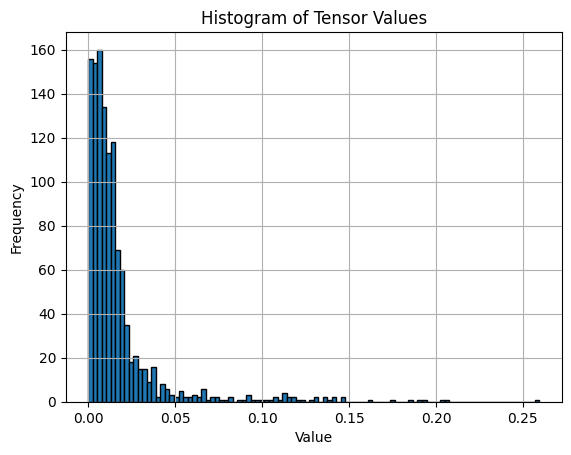

In [34]:
import matplotlib.pyplot as plt

# Example tensor (the same as your output)
tensor = (pred - Y).abs()


# Flatten the tensor to 1D for histogram plotting
flattened_tensor = tensor.view(-1).detach().numpy()

# Plot the histogram
plt.hist(flattened_tensor, bins=100, edgecolor='black')
plt.title('Histogram of Tensor Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [36]:
(pred - Y).abs().sum()/(pred - Y).numel()

tensor(0.0171, grad_fn=<DivBackward0>)

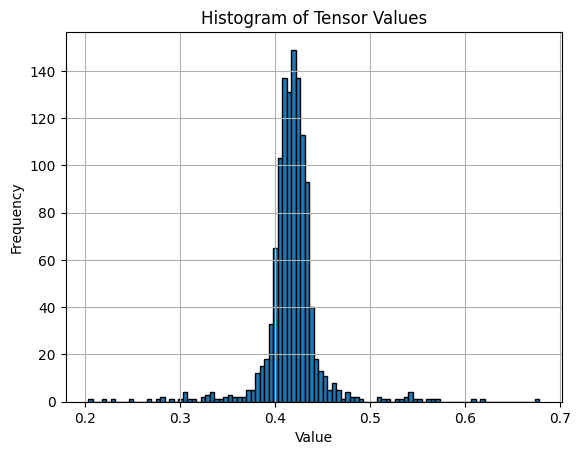

In [37]:
# Example tensor (the same as your output)
tensor = Y


# Flatten the tensor to 1D for histogram plotting
flattened_tensor = tensor.view(-1).detach().numpy()

# Plot the histogram
plt.hist(flattened_tensor, bins=100, edgecolor='black')
plt.title('Histogram of Tensor Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()